In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import StackingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from lightgbm import LGBMRegressor, early_stopping
from sklearn.model_selection import KFold, cross_val_score, train_test_split, learning_curve, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import shuffle, resample

In [18]:
data = pd.read_csv(r"/home/winter-storm/f1-data-project/erdos_ds_f1/Patrick/Feature Data Files/final features.csv")

continuous_features_dnf = ['driverExpWeightedSum', 'pitsWeightedSum', 'preRaceALPCWeightedSum', 'TCCAPE', 'clusterMeanWeightedSum',
                           'gapWeightedSum']
categorical_features_dnf = ['topTenDiversity', 'circuitId', 
                            'countryId', 'rain']

dnf_features = continuous_features_dnf + categorical_features_dnf

target = 'totalDNFs'

X_dnf = data[dnf_features]
y = data[target]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_dnf, y, 
                                                    test_size    = 0.2,
                                                    shuffle      = True,
                                                    random_state = 659)

k_fold = KFold(n_splits     = 7,
               shuffle      = True,
               random_state = 659)

In [51]:

handle_nans = Pipeline([
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('cont', handle_nans, continuous_features_dnf),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop='first'), categorical_features_dnf)
], remainder="passthrough")

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor_gbm = ColumnTransformer(
    transformers=[
        ('num', handle_nans, continuous_features_dnf),
        ('cat', categorical_transformer, categorical_features_dnf)
    ],
    remainder='drop'  # Just in case
)

preprocessor_rf = ColumnTransformer([
    ('cont', handle_nans, continuous_features_dnf),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop='first'), categorical_features_dnf)
], remainder="passthrough")

preprocessor_gb = ColumnTransformer([
    ('cont', handle_nans, continuous_features_dnf),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features_dnf)
], remainder="passthrough")

# Define base learners with your best parameters
lgb_model = LGBMRegressor(
    n_estimators      = 300,
    learning_rate     = 0.01,
    max_depth         = 3,
    min_child_samples = 30,
    subsample         = 0.6,
    colsample_bytree  = 1.0,
    random_state      = 659,
    verbose           = -1
)

rf_model = RandomForestRegressor(
    n_estimators      = 300,
    max_depth         = 10,
    max_features      = 0.5,
    min_samples_leaf  = 5,
    min_samples_split = 20,
    random_state      = 659,
    n_jobs            = -1
)

gb_model = HistGradientBoostingRegressor(
    l2_regularization = 1.0,
    learning_rate     = 0.05,
    max_depth         = 3,
    max_iter          = 500,
    max_leaf_nodes    = 31,
    min_samples_leaf  = 20,
    random_state      = 659
)

rf_pipeline = Pipeline([
    ('preprocess', preprocessor_rf),
    ('regress', rf_model)
])

gb_pipeline = Pipeline([
    ('preprocess', preprocessor_gb),
    ('regress', gb_model)
])

gbm_pipeline = Pipeline([
    ('preprocess', preprocessor_gbm),
    ('regress', lgb_model)
])

meta_model = LinearRegression()

xgb_meta_model = XGBRegressor(
    n_estimators     = 100,
    learning_rate    = 0.05,
    max_depth        = 3,
    subsample        = 0.6,
    colsample_bytree = 0.8,
    gamma            = 5,
    min_child_weight = 5,
    random_state     = 659,
    n_jobs           = -1
)

mlp_meta_model = MLPRegressor(
    hidden_layer_sizes=(100, 100),      # One hidden layer with 100 neurons
    activation='relu',              # Good default for most problems
    solver='adam',                  # Robust and works well for most data
    alpha=1.0,                   # Small L2 regularization
    learning_rate='constant',       # Keeps the learning rate fixed
    learning_rate_init=0.01,       # Typical default starting LR for adam
    max_iter=500,                   # More iterations to ensure convergence
    random_state=42,                # For reproducibility
    early_stopping=True,           # Stops if validation score doesn't improve
    validation_fraction=0.1,        # Fraction of training set for validation
    verbose=False                   # Set True if you want training logs
)

# Combine them in a stack
stack1 = StackingRegressor(
    estimators=[
        ('lgb', lgb_model),
        ('rf', rf_model),
        ('gb', gb_model)
    ],
    final_estimator = ElasticNetCV(),
    cv              = k_fold,
    passthrough     = False,  # True if you want meta-model to also use original features
    n_jobs          = -1
)

# Combine them in a stack
stack2 = StackingRegressor(
    estimators=[
        ('lgb', gbm_pipeline),
        ('rf', rf_pipeline),
        ('gb', gb_pipeline)
    ],
    final_estimator = ElasticNetCV(),
    cv              = k_fold,
    passthrough     = False,  # True if you want meta-model to also use original features
    n_jobs          = -1
)

# Full pipeline with preprocessing
stack_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # use the one you've already defined
    ('regressor', stack1)
])


In [52]:
stack2.fit(X_train, y_train)
y_pred = stack2.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Stacked Model Test MSE: {mse:.4f}")
print(f"Stacked Model Test R²: {r2:.4f}")

/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:1173: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2
/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:1173: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2
/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categorie

Stacked Model Test MSE: 6.4309
Stacked Model Test R²: 0.6745


In [53]:
def summarize_cv_results(results, model_name="Model"):
    r2_scores = results['test_r2']
    mse_scores = -results['test_neg_mean_squared_error']  # Convert back to positive MSE

    print(f"\n{model_name} Cross-Validation Summary:")
    print(f"Average R²: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
    print(f"Average MSE: {np.mean(mse_scores):.4f} ± {np.std(mse_scores):.4f}")

def plot_learning_curve(estimator, X_dnf, y, title="Learning Curve", cv=5):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X_dnf, y, cv=k_fold, scoring='r2',
        train_sizes=np.linspace(0.1, 1.0, 10),
        shuffle=True, random_state=42
    )

    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training R²')
    plt.plot(train_sizes, val_mean, 'o-', color='orange', label='Validation R²')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='orange')
    plt.xlabel('Training Set Size')
    plt.ylabel('R² Score')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:1173: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2
/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:1173: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2
/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:1173: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2
/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:1173: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2
/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:1173: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2
/home/winter-storm/anaconda3/lib/py

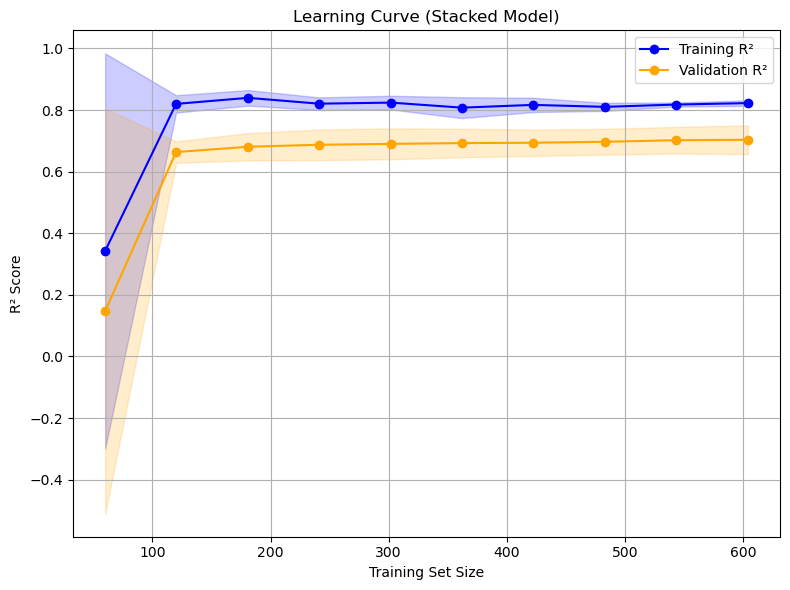

In [54]:
plot_learning_curve(stack2, X_dnf, y, title="Learning Curve (Stacked Model)", cv=k_fold)

In [39]:
param_grid = {
    'final_estimator__n_estimators': [100, 200, 300],
    'final_estimator__max_depth': [3, 5, 7, 10],
    'final_estimator__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'final_estimator__subsample': [0.6, 0.8, 1.0],
    'final_estimator__colsample_bytree': [0.6, 0.8, 1.0],
    'final_estimator__gamma': [0, 1, 5],
    'final_estimator__min_child_weight': [1, 3, 5]
}

mlp_param_grid = {
    'final_estimator__hidden_layer_sizes': [(50,), (100,), (100, 50), (50, 50), (100, 100)],
    'final_estimator__activation': ['relu', 'tanh'],
    'final_estimator__solver': ['adam', 'lbfgs'],  # You could add 'sgd' but it's more sensitive to learning rate
    'final_estimator__alpha': [0.0001, 0.001, 0.01],  # L2 penalty (regularization)
    'final_estimator__learning_rate': ['constant', 'adaptive'],
    'final_estimator__learning_rate_init': [0.001, 0.01],
    'final_estimator__max_iter': [200, 500]
}


search = RandomizedSearchCV(
    estimator=stack2,
    param_distributions=mlp_param_grid,
    n_iter=100,  # Try 100 instead of 3888 combinations
    scoring='r2',
    cv=k_fold,
    n_jobs=-1,
    verbose=0,
    random_state=659
)
search.fit(X_train, y_train)

search.fit(X_train, y_train)
print("Best R² on validation:", search.best_score_)
print("Best meta-model params:", search.best_params_)

/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:1173: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2
/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encode

Best R² on validation: 0.6943791266368559
Best meta-model params: {'final_estimator__solver': 'adam', 'final_estimator__max_iter': 500, 'final_estimator__learning_rate_init': 0.01, 'final_estimator__learning_rate': 'constant', 'final_estimator__hidden_layer_sizes': (100, 100), 'final_estimator__alpha': 0.001, 'final_estimator__activation': 'relu'}


In [40]:
y_pred = search.best_estimator_.predict(X_test)
print("Test R²:", r2_score(y_test, y_pred))
print("Test MSE:", mean_squared_error(y_test, y_pred))

Test R²: 0.6835552158701667
Test MSE: 6.2524943464554665


/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:1173: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2
/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:1173: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2
/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:1173: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2
/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:1173: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2
/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  

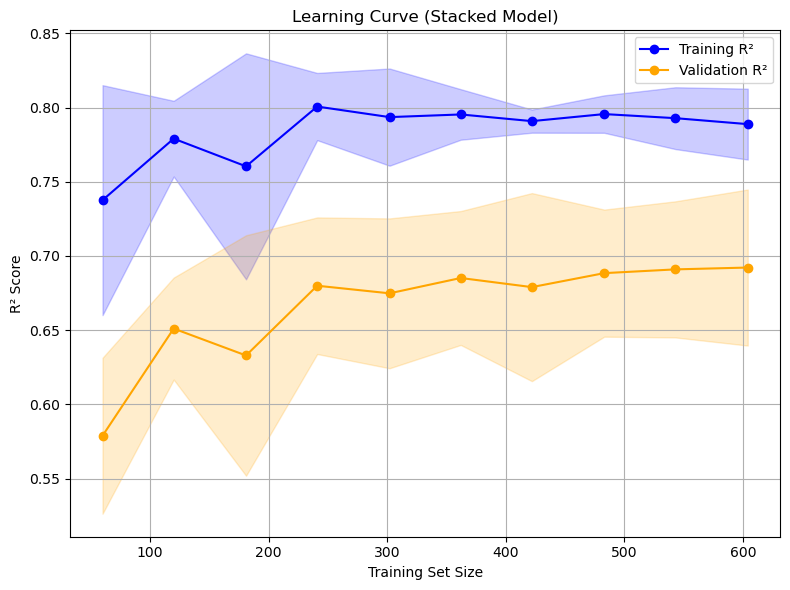

In [41]:
best_stacked_model = search.best_estimator_
plot_learning_curve(best_stacked_model, X_dnf, y, title="Learning Curve (Stacked Model)", cv=k_fold)

/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:1173: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2
/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:1173: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2
/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categorie

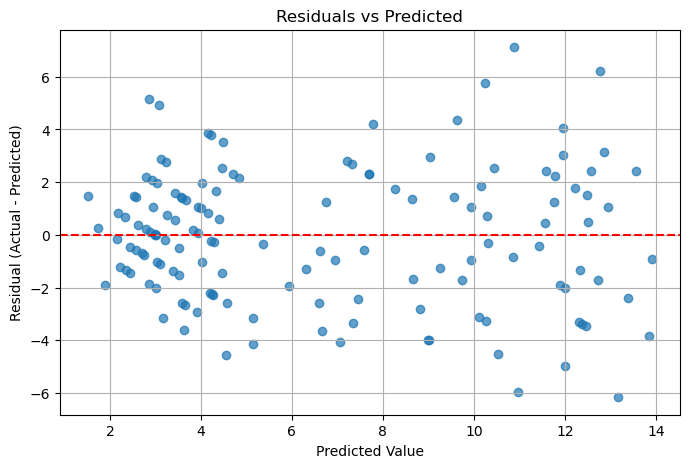

In [55]:
stack_model = stack2.fit(X_train, y_train)
y_pred = stack2.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Value')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residuals vs Predicted')
plt.grid(True)
plt.show()

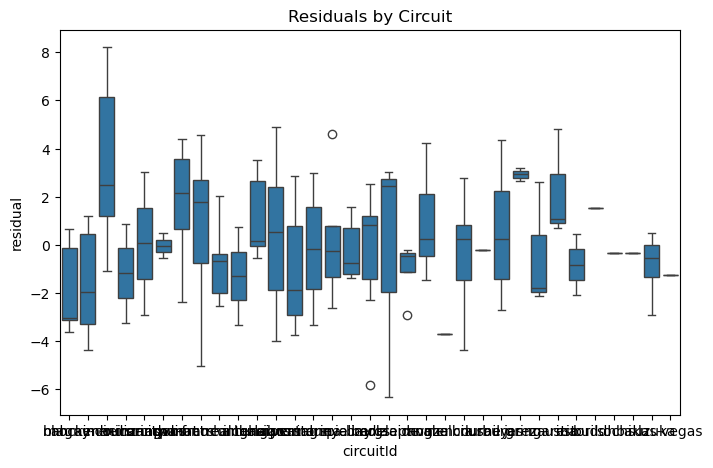

In [ ]:
# Combine for analysis
error_df = X_test.copy()
error_df['residual'] = residuals
error_df['actual'] = y_test
error_df['predicted'] = y_pred

# Plot example
plt.figure(figsize=(8, 5))
sns.boxplot(data=error_df, x='circuitId', y='residual')
plt.title('Residuals by Circuit')
plt.show()

In [56]:
rf_mod = rf_pipeline.fit(X_train, y_train)
gb_mod = gb_pipeline.fit(X_train, y_train)
lgb_mod = gbm_pipeline.fit(X_train, y_train)

rf_preds = rf_mod.predict(X_test)
gb_preds = gb_mod.predict(X_test)
lgb_preds = lgb_mod.predict(X_test)

In [57]:
X_blend = np.vstack([rf_preds, gb_preds, lgb_preds]).T
ridge = Ridge(alpha=1.0, fit_intercept=False)
ridge.fit(X_blend, y_test)

print("Blending weights:", ridge.coef_)

blended_preds = ridge.predict(X_blend)

Blending weights: [ 0.91203013  0.62948664 -0.55143388]


In [58]:
blended_preds = 0.91203013 * rf_preds + 0.62948664 * gb_preds + -0.55143388 * lgb_preds

In [59]:
mse_blend = mean_squared_error(y_test, blended_preds)
r2_blend = r2_score(y_test, blended_preds)

print(f"Blended Model Test MSE: {mse_blend:.4f}")
print(f"Blended Model Test R²: {r2_blend:.4f}")

Blended Model Test MSE: 5.9370
Blended Model Test R²: 0.6995


In [60]:
def blend_predictions(X, weights=(0.91203013, 0.62948664, -0.55143388)):
    rf_preds = rf_mod.predict(X)
    gb_preds = gb_mod.predict(X)
    lgb_preds = lgb_mod.predict(X)
    w = weights
    return w[0] * rf_preds + w[1] * gb_preds + w[2] * lgb_preds

/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/winter-storm/ana

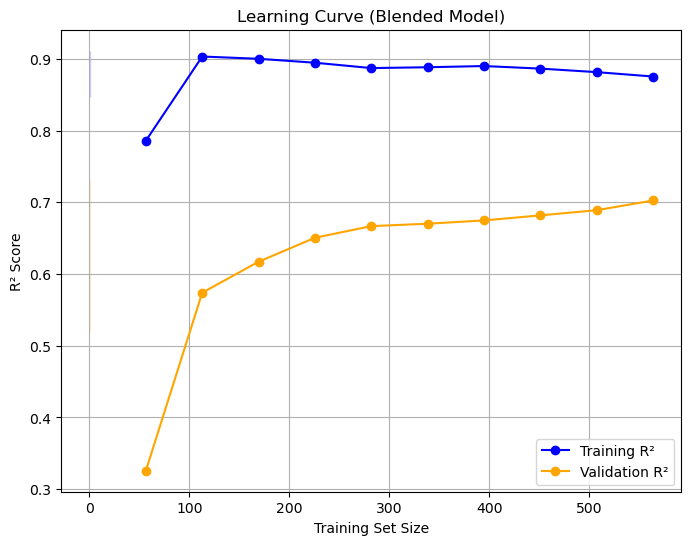

In [ ]:
train_sizes = np.linspace(0.1, 1.0, 10)
train_scores, val_scores = [], []

X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train, random_state=42)

for frac in train_sizes:
    subset_size = int(frac * len(X_train))
    X_sub, y_sub = X_train_shuffled[:subset_size], y_train_shuffled[:subset_size]
    
    # Refit base models (important)
    rf_pipeline.fit(X_sub, y_sub)
    gb_pipeline.fit(X_sub, y_sub)
    gbm_pipeline.fit(X_sub, y_sub)
    
    # Blended predictions
    train_preds = blend_predictions(X_sub)
    val_preds = blend_predictions(X_test)

    train_r2 = r2_score(y_sub, train_preds)
    val_r2 = r2_score(y_test, val_preds)

    train_scores.append(train_r2)
    val_scores.append(val_r2)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(train_sizes * len(X_train), train_scores, 'b-o', label='Training R²')
plt.plot(train_sizes * len(X_train), val_scores, 'orange', marker='o', label='Validation R²')
plt.title("Learning Curve (Blended Model)")
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.legend()
plt.grid(True)
plt.show()

/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/winter-storm/

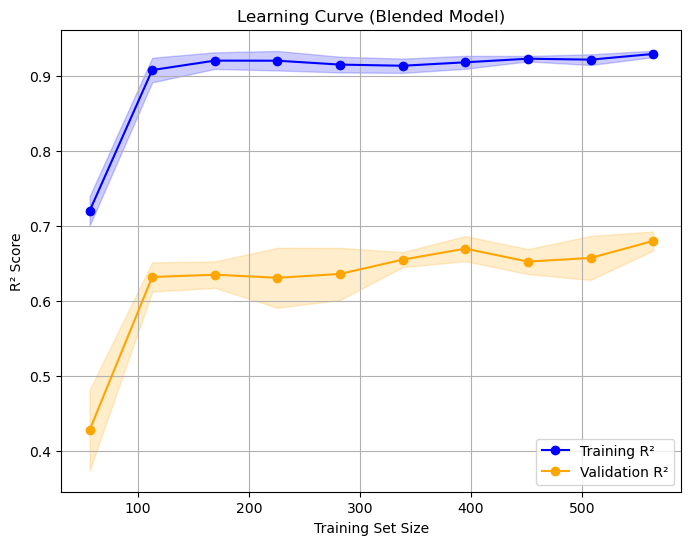

In [82]:
n_repeats = 5  # How many times to repeat each size

train_sizes = np.linspace(0.1, 1.0, 10)
train_means, val_means, train_stds, val_stds = [], [], [], []

for frac in train_sizes:
    train_r2s, val_r2s = [], []

    for _ in range(n_repeats):
        # Sample data
        X_sub, y_sub = resample(X_train, y_train, n_samples=int(frac * len(X_train)), random_state=None)
        
        # Refit models
        rf_pipeline.fit(X_sub, y_sub)
        gb_pipeline.fit(X_sub, y_sub)
        gbm_pipeline.fit(X_sub, y_sub)

        # Predict
        train_preds = blend_predictions(X_sub)
        val_preds = blend_predictions(X_test)

        train_r2s.append(r2_score(y_sub, train_preds))
        val_r2s.append(r2_score(y_test, val_preds))

    train_means.append(np.mean(train_r2s))
    val_means.append(np.mean(val_r2s))
    train_stds.append(np.std(train_r2s))
    val_stds.append(np.std(val_r2s))

# Plot
train_sizes_abs = train_sizes * len(X_train)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes_abs, train_means, 'b-o', label='Training R²')
plt.fill_between(train_sizes_abs, np.array(train_means) - train_stds, np.array(train_means) + train_stds, alpha=0.2, color='blue')

plt.plot(train_sizes_abs, val_means, 'orange', marker='o', label='Validation R²')
plt.fill_between(train_sizes_abs, np.array(val_means) - val_stds, np.array(val_means) + val_stds, alpha=0.2, color='orange')

plt.title("Learning Curve (Blended Model)")
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.legend()
plt.grid(True)
plt.show()


/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:1173: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2
/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:1173: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2
/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categorie

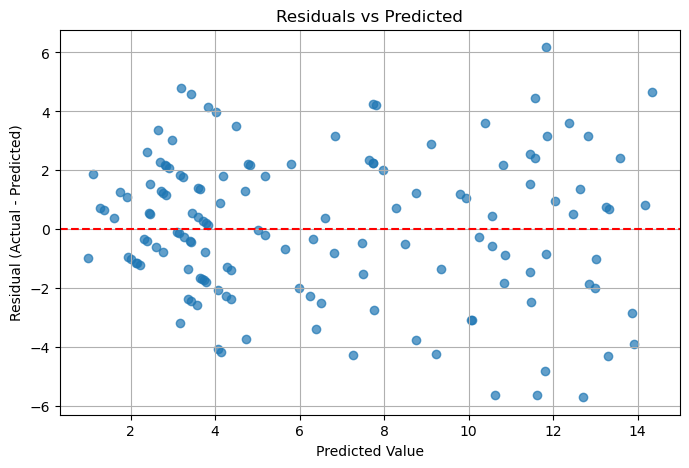

In [62]:
stack_model = stack2.fit(X_train, y_train)
y_pred = blend_predictions(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Value')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residuals vs Predicted')
plt.grid(True)
plt.show()

In [75]:
# Start making the resifduals model 
blended_train_preds = blend_predictions(X_train)
blended_test_preds = blend_predictions(X_test)

residuals = y_train - blended_train_preds

residual_X_train = preprocessor.fit_transform(X_train)
residual_X_test  = preprocessor.transform(X_test)

/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [76]:
residual_model = RandomForestRegressor(n_estimators=100, random_state=659)
residual_model.fit(residual_X_train, residuals)

RandomForestRegressor(random_state=659)

In [78]:
residual_correction = residual_model.predict(residual_X_test)
final_preds = blended_test_preds + residual_correction

In [79]:
r2 = r2_score(y_test, final_preds)
mse = mean_squared_error(y_test, final_preds)

print(f"Residual-boosted Model R²: {r2:.4f}")
print(f"Residual-boosted Model MSE: {mse:.4f}")

Residual-boosted Model R²: 0.6949
Residual-boosted Model MSE: 6.0275


/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/winter-storm/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/winter-storm/ana

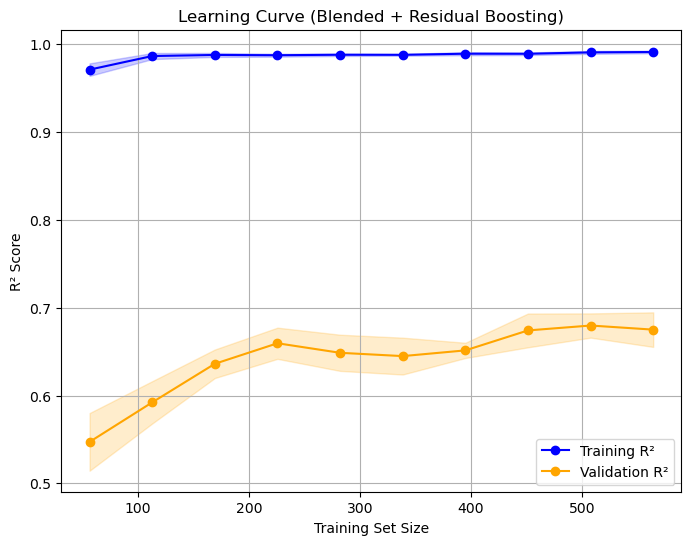

In [81]:
train_sizes = np.linspace(0.1, 1.0, 10)
n_repeats = 5  # for averaging

train_r2_means, val_r2_means = [], []
train_r2_stds, val_r2_stds = [], []

for frac in train_sizes:
    train_r2s = []
    val_r2s = []

    for _ in range(n_repeats):
        # 1. Sample subset of training data
        X_sub, y_sub = resample(X_train, y_train, n_samples=int(frac * len(X_train)), random_state=None)

        # 2. Fit base models and blended predictions
        rf_pipeline.fit(X_sub, y_sub)
        gb_pipeline.fit(X_sub, y_sub)
        gbm_pipeline.fit(X_sub, y_sub)
        
        blended_train_preds = blend_predictions(X_sub)
        blended_val_preds   = blend_predictions(X_test)

        # 3. Fit residual model using preprocessed data
        preprocessor = rf_pipeline.named_steps["preprocess"]
        residual_X_sub = preprocessor.transform(X_sub)
        residual_X_test = preprocessor.transform(X_test)
        
        residuals = y_sub - blended_train_preds
        residual_model = RandomForestRegressor(n_estimators=100, random_state=42)
        residual_model.fit(residual_X_sub, residuals)

        # 4. Apply residual correction
        corrected_train_preds = blended_train_preds + residual_model.predict(residual_X_sub)
        corrected_val_preds   = blended_val_preds + residual_model.predict(residual_X_test)

        # 5. Compute R²
        train_r2s.append(r2_score(y_sub, corrected_train_preds))
        val_r2s.append(r2_score(y_test, corrected_val_preds))

    # 6. Aggregate stats
    train_r2_means.append(np.mean(train_r2s))
    train_r2_stds.append(np.std(train_r2s))
    val_r2_means.append(np.mean(val_r2s))
    val_r2_stds.append(np.std(val_r2s))

# 7. Plotting
train_sizes_abs = train_sizes * len(X_train)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes_abs, train_r2_means, 'b-o', label='Training R²')
plt.fill_between(train_sizes_abs, 
                 np.array(train_r2_means) - train_r2_stds, 
                 np.array(train_r2_means) + train_r2_stds, 
                 alpha=0.2, color='blue')

plt.plot(train_sizes_abs, val_r2_means, 'orange', marker='o', label='Validation R²')
plt.fill_between(train_sizes_abs, 
                 np.array(val_r2_means) - val_r2_stds, 
                 np.array(val_r2_means) + val_r2_stds, 
                 alpha=0.2, color='orange')

plt.title("Learning Curve (Blended + Residual Boosting)")
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.legend()
plt.grid(True)
plt.show()
